## Simulated butterfly dataset

To illustrate the power of IntegrAO, we include an example of applying IntegrAO to simulated butterfly datasets originally coming from butterfly images. We use two different common encoding methods (Fisher Vector (FV) and Vector of Linearly Aggregated Descriptors (VLAD) with dense SIFT) to generate two different vectorizations of each image. These two encoding methods describe the content of the images differently and therefore capture different information about the images.

The first dataset has 1032 samples and the second has 1132 samples. There are 832 common samples from the 2 datasets, which means 200 samples are unique for dataset1 and 300 samples are unique for dataset2. The IntegrAO will perform integration for all the samples and product a final graph of union 1332 samples

## Import packages and IntegrAO code

In [1]:
import numpy as np
import pandas as pd
import snf
from sklearn.cluster import spectral_clustering
from sklearn.metrics import v_measure_score
import matplotlib.pyplot as plt

import sys
import os
import argparse
import torch

In [2]:

d = os.path.dirname(os.getcwd())
sys.path.insert(0, d)
from integrao.dataset import GraphDataset
from integrao.main import dist2
from integrao.integrater import integrao_integrater

## Set hyperparameters

In [3]:
# Hyperparameters
neighbor_size = 20
embedding_dims = 64
fusing_iteration = 20
normalization_factor = 1.0
alighment_epochs = 1000
beta = 1.0
mu = 0.5
dataset_name = 'butterfly'

## Read data

In [4]:
# read the data
testdata_dir = os.path.join(d, "data/butterfly/")
w1_ = os.path.join(testdata_dir, "w1.csv")
w2_ = os.path.join(testdata_dir, "w2.csv")
w1 = pd.read_csv(w1_, index_col=0)
w2 = pd.read_csv(w2_, index_col=0)

label = ["label"]
w1_label = w1[label]
w2_label = w2[label]
wcom_label = w1_label.filter(regex="^common_", axis=0)
w1.drop(label, axis=1, inplace=True)
w2.drop(label, axis=1, inplace=True)
wall_label = pd.concat([w1_label, w2_label], axis=0)
wall_label = wall_label[~wall_label.index.duplicated(keep="first")]

In [5]:
print("W1 shape: ", w1.shape) 
print("W2 shape: ", w2.shape) 

W1 shape:  (1032, 500)
W2 shape:  (1132, 500)


In [6]:
wall_label

,label
common_0,1
common_1,1
common_2,1
common_3,1
common_4,1
...,...
x2_1127,10
x2_1128,10
x2_1129,10
x2_1130,10


## Let's check the clustering perforamance before integration

In [7]:
Dist1 = dist2(w1.values, w1.values)
Dist2 = dist2(w2.values, w2.values)

S1 = snf.compute.affinity_matrix(Dist1, K=neighbor_size, mu=mu)
S2 = snf.compute.affinity_matrix(Dist2, K=neighbor_size, mu=mu)

labels_s1 = spectral_clustering(S1, n_clusters=10)
score1 = v_measure_score(w1_label["label"].tolist(), labels_s1)
print("Before diffusion for full 1032 p1 NMI score: ", score1)

labels_s2 = spectral_clustering(S2, n_clusters=10)
score2 = v_measure_score(w2_label["label"].tolist(), labels_s2)
print("Before diffusion for full 1132 p2 NMI score:", score2)

Before diffusion for full 1032 p1 NMI score:  0.5741818872312777
Before diffusion for full 1132 p2 NMI score: 0.5907531328249137


## SNFplus integration

In [8]:
integrater = integrao_integrater(
    [w1, w2],
    dataset_name,
    neighbor_size=neighbor_size,
    embedding_dims=embedding_dims,
    fusing_iteration=fusing_iteration,
    normalization_factor=normalization_factor,
    alighment_epochs=alighment_epochs,
    beta=beta,
    mu=mu,
)

# IntegrAO
fused_networks = integrater.network_diffusion()
embeds_final, S_final, model = integrater.unsupervised_alignment()

labels = spectral_clustering(S_final, n_clusters=10)

score_all = v_measure_score(wall_label.sort_index()["label"].tolist(), labels)
print("IntegrAO for clustering intersecting 1332 samples NMI score: ", score_all)

Start indexing input expression matrices!
Common sample between view0 and view1: 832
Neighbor size: 20
Start applying diffusion!
Diffusion ends! Times: 19.33192539215088s
Starting unsupervised exmbedding extraction!
Dataset 0: (1032, 500)
Dataset 1: (1132, 500)
epoch 0: loss 25.375762939453125, align_loss:0.234063
epoch 100: loss 18.469186782836914, align_loss:0.047067
epoch 200: loss 1.8583803176879883, align_loss:0.017644
epoch 300: loss 1.857518196105957, align_loss:0.017015
epoch 400: loss 1.8565350770950317, align_loss:0.016346
epoch 500: loss 1.8554542064666748, align_loss:0.015667
epoch 600: loss 1.8542917966842651, align_loss:0.014990
epoch 700: loss 1.8530604839324951, align_loss:0.014323
epoch 800: loss 1.8517637252807617, align_loss:0.013662
epoch 900: loss 1.8504120111465454, align_loss:0.013013
Manifold alignment ends! Times: 81.69554734230042s
IntegrAO for clustering intersecting 1332 samples NMI score:  0.771409424812544


# UMAP plot

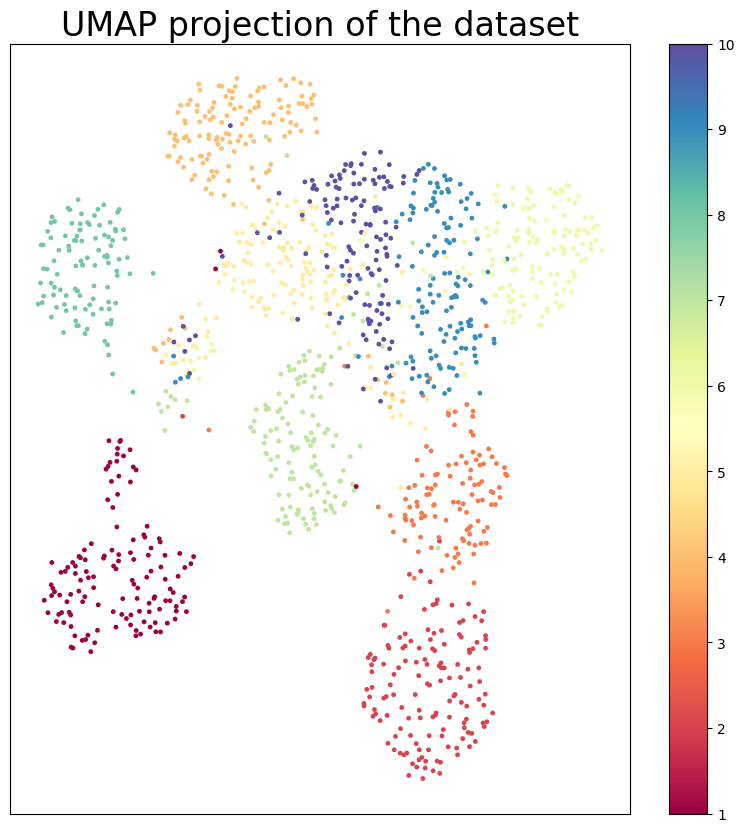

In [10]:
import umap

# umap visualization of embeddings with hue as labels
reducer = umap.UMAP(n_neighbors=30, min_dist=1.0, spread=1.0)
embedding = reducer.fit_transform(embeds_final.values)
plt.figure(figsize=(10, 10))
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=wall_label.sort_index()["label"].tolist(),
    s=6,
    cmap="Spectral",
    alpha=1.0,
)
plt.setp(plt.gca(), xticks=[], yticks=[])
plt.title("UMAP projection of the dataset", fontsize=24)
plt.colorbar()
plt.show()